# Instalação de Bibliotecas Necessárias

In [ ]:
!pip install nltk scikit-learn textblob keras
!pip install tensorflow


In [ ]:
# Importação de bibliotecas essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GlobalMaxPooling1D


# Baixar pacotes do nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Carregar dados do CSV
data = pd.read_csv('/content/movies(from_14_Aug_to_25_Sep_24).csv')

# Remover colunas com todos os valores NaN
data = data.dropna(axis=1, how='all')

# Remover valores NaN da coluna 'overview'
data = data.dropna(subset=['overview'])
data.head()

,Unnamed: 0,id,title,overview,release_date,popularity,vote_average,vote_count,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,0,957452,The Crow,Soulmates Eric and Shelly are brutally murdere...,2024-08-21,4065.642,5.314,287,NaN,NaN,NaN
1,1,519182,Despicable Me 4,"Gru and Lucy and their girls—Margo, Edith and ...",2024-06-20,1743.127,7.169,1670,NaN,NaN,NaN
2,2,365177,Borderlands,"Returning to her home planet, an infamous boun...",2024-08-07,1689.252,5.898,566,NaN,NaN,NaN
3,3,917496,Beetlejuice Beetlejuice,"After a family tragedy, three generations of t...",2024-09-04,1434.179,7.122,641,NaN,NaN,NaN
4,4,646097,Rebel Ridge,A former Marine confronts corruption in a smal...,2024-08-27,1107.009,7.04,633,NaN,NaN,NaN


In [ ]:
import pandas as pd

# Função para mapear as tags de POS do nltk para as tags que o WordNetLemmatizer pode usar
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjetivo
    elif tag.startswith('V'):
        return 'v'  # Verbo
    elif tag.startswith('N'):
        return 'n'  # Substantivo
    elif tag.startswith('R'):
        return 'r'  # Advérbio
    else:
        return 'n'  # Tratar como substantivo por padrão

# Função para pré-processar o texto com visualização do processo
def preprocess_and_visualize(text):
    text = text.lower()  # Colocar texto em minúsculas
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remover URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remover e-mails
    text = re.sub(r'\d+', '', text)  # Remover números
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remover pontuações

    # Tokenização
    tokens = word_tokenize(text)

    # Remoção de stopwords
    stop_words = set(stopwords.words('english'))
    tokens_clean = [word for word in tokens if word not in stop_words]

    # POS-tagging
    pos_tags = pos_tag(tokens_clean)

    # Lemmatização com base nas POS-tags
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

    # Visualizar os resultados em um DataFrame
    df_comparison = pd.DataFrame({
        'Token': tokens_clean,
        'POS-tag': [tag for _, tag in pos_tags],
        'Lemmatized': lemmatized_tokens
    })

    return df_comparison

# Exemplo de uso
text_example = "The striped bats are hanging on their feet for best."
df_result = preprocess_and_visualize(text_example)
print(df_result)


     Token POS-tag Lemmatized
0  striped     VBN      strip
1     bats     NNS        bat
2  hanging     VBG       hang
3     feet     NNS       foot
4     best      RB       best


In [ ]:
# Função para realizar análise de sentimentos
def sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity


In [ ]:
# Aplicar o pré-processamento e análise de sentimentos em cada comentário
processed_texts = []
sentiments = []

for text in data['overview']:
    processed_text = preprocess_text(text)
    polarity, subjectivity = sentiment_analysis(processed_text)

    processed_texts.append(processed_text)
    sentiments.append((polarity, subjectivity))

# Adicionar as colunas de texto processado e sentimentos ao dataframe
data['processed_overview'] = processed_texts
data['sentiment_polarity'] = [s[0] for s in sentiments]
data['sentiment_subjectivity'] = [s[1] for s in sentiments]

# Exibir os primeiros resultados processados
print(data[['overview', 'processed_overview', 'sentiment_polarity', 'sentiment_subjectivity']].head())


                                            overview  \
0  Soulmates Eric and Shelly are brutally murdere...   
1  Gru and Lucy and their girls—Margo, Edith and ...   
2  Returning to her home planet, an infamous boun...   
3  After a family tragedy, three generations of t...   
4  A former Marine confronts corruption in a smal...   

                                  processed_overview  sentiment_polarity  \
0  soulmates eric shelly brutally murder demon da...           -0.140292   
1  gru lucy girls—margo edith agnes—welcome new m...            0.136364   
2  return home planet infamous bounty hunter form...           -0.233333   
3  family tragedy three generation deetz family r...            0.000000   
4  former marine confronts corruption small town ...           -0.083333   

   sentiment_subjectivity  
0                0.623571  
1                0.454545  
2                0.800000  
3                0.250000  
4                0.133333  


In [ ]:
# Função para criar a Bag of Words
def create_bag_of_words(texts):
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(texts)
    return bag_of_words.toarray(), vectorizer.get_feature_names_out()

# Criar a Bag of Words para os textos processados
bag_of_words, feature_names = create_bag_of_words(processed_texts)

# Exibir Bag of Words e as features
print("Bag of Words:", bag_of_words)
print("Features:", feature_names)


Bag of Words: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Features: ['aa' 'aaa' 'aachal' ... 'λιτος' 'сronos' '鳥居']


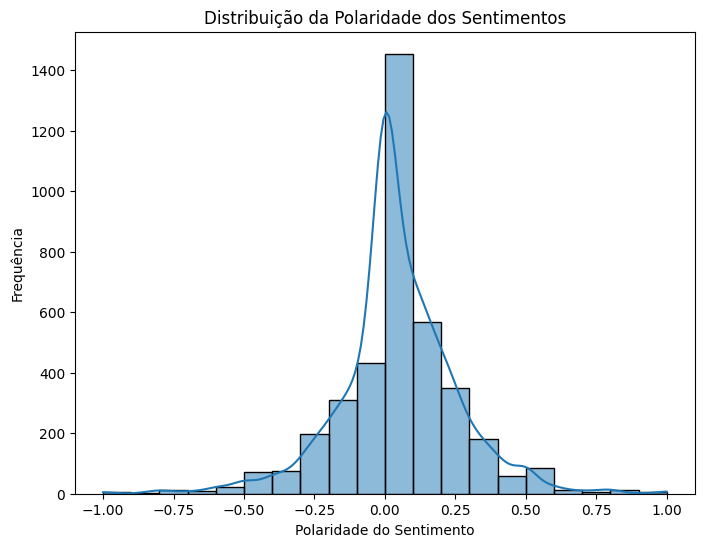

In [ ]:
# Visualizar a distribuição da polaridade dos sentimentos
plt.figure(figsize=(8, 6))
sns.histplot(data['sentiment_polarity'], bins=20, kde=True)
plt.title('Distribuição da Polaridade dos Sentimentos')
plt.xlabel('Polaridade do Sentimento')
plt.ylabel('Frequência')
plt.show()


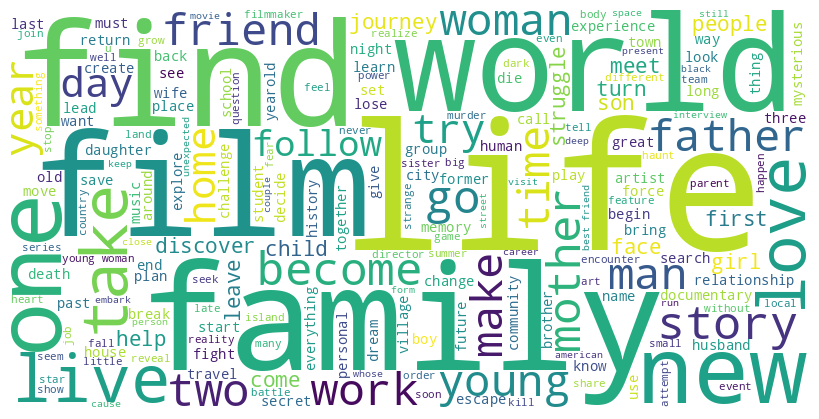

In [ ]:
# Gerar uma Word Cloud a partir dos textos processados
text = ' '.join(data['processed_overview'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


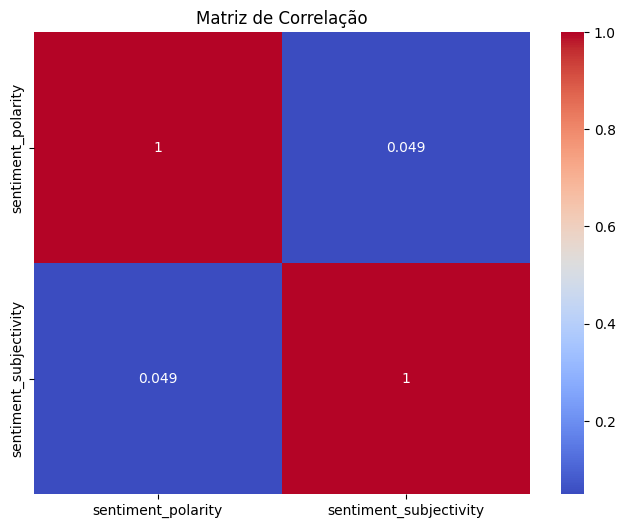

In [ ]:
# Visualizar a matriz de correlação
correlation_matrix = data[['sentiment_polarity', 'sentiment_subjectivity']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


In [ ]:
# Converter a coluna 'vote_average' para float, forçando erros a NaN
data['vote_average'] = pd.to_numeric(data['vote_average'], errors='coerce')

# Verificar se há valores nulos após a conversão
print(data['vote_average'].isnull().sum())

# Gerar a coluna 'sentiment' com base no 'vote_average'
data['sentiment'] = data['vote_average'].apply(lambda x: 1 if x >= 6.0 else 0 if pd.notnull(x) else None)

# Verificar as primeiras linhas para confirmar
print(data[['vote_average', 'sentiment']].head())


11
   vote_average  sentiment
0         5.314        0.0
1         7.169        1.0
2         5.898        0.0
3         7.122        1.0
4         7.040        1.0


In [ ]:
from textblob import TextBlob

# Função para analisar sentimento com TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return 1 if analysis.sentiment.polarity > 0 else 0

# Aplicar a função de sentimento na coluna 'overview'
data['sentiment'] = data['overview'].apply(get_sentiment)

# Verifique as primeiras linhas para confirmar
print(data[['overview', 'sentiment']].head())


                                            overview  sentiment
0  Soulmates Eric and Shelly are brutally murdere...          0
1  Gru and Lucy and their girls—Margo, Edith and ...          1
2  Returning to her home planet, an infamous boun...          0
3  After a family tragedy, three generations of t...          0
4  A former Marine confronts corruption in a smal...          0


In [ ]:
import pandas as pd
from textblob import TextBlob

# Função para analisar sentimento com TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return 1 if analysis.sentiment.polarity > 0 else 0

# Converter a coluna 'vote_average' para float, forçando erros a NaN
data['vote_average'] = pd.to_numeric(data['vote_average'], errors='coerce')

# Função para calcular o sentimento combinado
def combined_sentiment(row):
    # Analisar sentimento do overview
    text_sentiment = get_sentiment(row['overview'])

    # Analisar sentimento da média de votos
    if pd.notnull(row['vote_average']):
        vote_sentiment = 1 if row['vote_average'] >= 6.0 else 0
    else:
        vote_sentiment = None

    # Combinar os dois sentimentos
    if vote_sentiment is not None:
        return round((text_sentiment + vote_sentiment) / 2)  # Média dos dois
    else:
        return text_sentiment  # Usar só o sentimento do texto se 'vote_average' for nulo

# Aplicar a função para criar a nova coluna 'combined_sentiment'
data['combined_sentiment'] = data.apply(combined_sentiment, axis=1)

# Verifique as primeiras linhas para confirmar
print(data[['vote_average', 'overview', 'combined_sentiment']].head())


   vote_average                                           overview  \
0         5.314  Soulmates Eric and Shelly are brutally murdere...   
1         7.169  Gru and Lucy and their girls—Margo, Edith and ...   
2         5.898  Returning to her home planet, an infamous boun...   
3         7.122  After a family tragedy, three generations of t...   
4         7.040  A former Marine confronts corruption in a smal...   

   combined_sentiment  
0                   0  
1                   1  
2                   0  
3                   0  
4                   0  


In [ ]:
# Preparar os dados para a Rede Neural
X = data['processed_overview']
y = data['sentiment']  # Rótulo binário de sentimento (0 para negativo, 1 para positivo)

# Tokenização e sequenciamento dos textos
max_words = 5000  # Limite de palavras no vocabulário
max_len = 100  # Tamanho máximo das sequências
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_len)

# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo LSTM
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.5806 - loss: 0.6758 - val_accuracy: 0.6994 - val_loss: 0.5635
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.8287 - loss: 0.4166 - val_accuracy: 0.7626 - val_loss: 0.5110
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9317 - loss: 0.1987 - val_accuracy: 0.7394 - val_loss: 0.5767
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9808 - loss: 0.0741 - val_accuracy: 0.7200 - val_loss: 0.9066
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.9929 - loss: 0.0303 - val_accuracy: 0.7355 - val_loss: 1.1521


In [ ]:
# Fazer previsões com o conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Converter probabilidades em classes binárias

# Avaliar a precisão
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Gerar o relatório de classificação
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step
Accuracy: 0.7355
Confusion Matrix:
[[273 108]
 [ 97 297]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       381
           1       0.73      0.75      0.74       394

    accuracy                           0.74       775
   macro avg       0.74      0.74      0.74       775
weighted avg       0.74      0.74      0.74       775

